In [4]:
from osgeo import gdal,gdalnumeric
import numpy
import os
from glob import * 
import glob
from rio_toa.toa_utils import  _parse_bands_from_filename
import numpy as np

In [5]:
def get_rednir_path(input_path):
    rgb_path=[]
    search_criteria = "*TIF"
    glob_criteria = os.path.join(input_path, search_criteria)
    img_list = glob.glob(glob_criteria)    
    for img in img_list:
        #print(img)
        try:            
            bandnum = _parse_bands_from_filename([img], '.*/*LC08.*\_B{b}.TIF')
        except ValueError:
            continue
        if bandnum[0] ==4 :
            rgb_path.insert(0,img)
        if bandnum[0] ==5 :
            rgb_path.insert(1,img)

    return rgb_path

In [6]:
dirpath=r'../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA'

In [8]:
#calculate one image
search_criteria = '*TIF'
glob_creteria= os.path.join(dirpath, search_criteria)
landsatimages = sorted(glob.glob(glob_creteria))
rednir=[get_rednir_path(dirpath)]
rednir

[['../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172034_20180704_20180717_01_T1_B4.TIF',
  '../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172034_20180704_20180717_01_T1_B5.TIF']]

In [24]:
#calculate more than 1 image, you should find the Landsat folders
dirpath=r'../mardin/'
search_criteria = '*/*TOA'
glob_creteria= os.path.join(dirpath, search_criteria)
#print(glob_creteria)
landsatfolders = sorted(glob.glob(glob_creteria))
rednir_list=[get_rednir_path(input_path) for input_path in landsatfolders ]
rednir_list=sorted(rednir_list)
rednir_list

[['../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172034_20180704_20180717_01_T1_B4.TIF',
  '../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172034_20180704_20180717_01_T1_B5.TIF'],
 ['../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/LC08_L1TP_172035_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172035_20180704_20180717_01_T1_B4.TIF',
  '../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/LC08_L1TP_172035_20180704_20180717_01_T_TOA/TOA_LC08_L1TP_172035_20180704_20180717_01_T1_B5.TIF'],
 ['../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T_TOA/TOA_LC08_L1TP_173034_20180711_20180717_01_T1_B4.TIF',
  '../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T_TOA/TOA_LC08_L1TP_173034_20180711_20180717_01_T1_B5.TIF']]

In [9]:
def calculate_ndvi (images_list,*output_path):
    for landsat_bands in images_list:        
        #print(landsat_bands[0])
        output_path=os.path.dirname(landsat_bands[0])
        g = gdal.Open(landsat_bands[0])        
        red = g.ReadAsArray()
        g = gdal.Open(landsat_bands[1])        
        nir = g.ReadAsArray()
        red = numpy.array(red, dtype = float)
        nir = numpy.array(nir, dtype = float)
        check = numpy.logical_and ( red > 0, nir > 0 )
        numpy.seterr(divide='ignore', invalid='ignore')
        ndvi = (nir - red ) / ( nir + red )
        ndvi_name=os.path.basename(output_path)+'_NDVI.TIF'
        output_path=output_path + '/'+ ndvi_name
        print(output_path)
        geo = g.GetGeoTransform()  
        proj = g.GetProjection()   
        shape = red.shape        
        driver = gdal.GetDriverByName("GTiff")
        dst_ds = driver.Create( output_path, shape[1], shape[0], 1, gdal.GDT_Float32)
        dst_ds.SetGeoTransform( geo )
        dst_ds.SetProjection( proj ) 
        dst_ds.GetRasterBand(1).WriteArray(ndvi)
        dst_ds = None
    
    return ndvi
        

In [25]:
ndvi=calculate_ndvi(rednir_list)

../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/LC08_L1TP_172034_20180704_20180717_01_T_TOA_NDVI.TIF
../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/LC08_L1TP_172035_20180704_20180717_01_T_TOA/LC08_L1TP_172035_20180704_20180717_01_T_TOA_NDVI.TIF
../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T_TOA/LC08_L1TP_173034_20180711_20180717_01_T_TOA_NDVI.TIF


In [26]:
import matplotlib  
import matplotlib.pyplot as plt

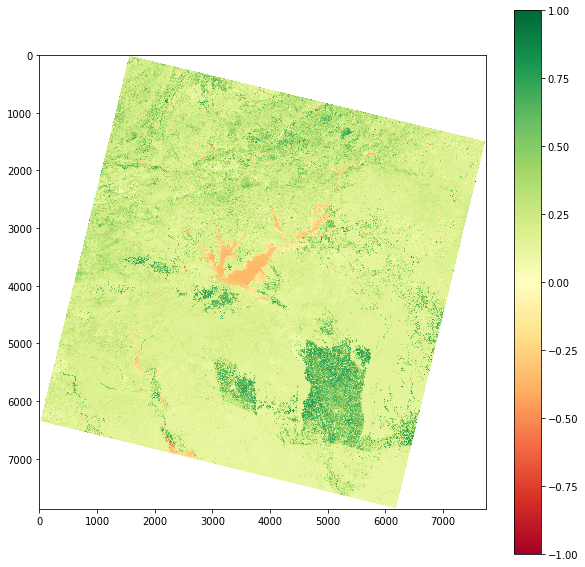

In [27]:
fig=plt.figure(figsize=(10,10))
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar()
plt.show()


### Create NDVI stack

In [28]:
from glob import glob
ndvi_folders='../mardin/'
search_criteria = "*/*/*NDVI.TIF"
glob_creteria = os.path.join(ndvi_folders, search_criteria)
glob_creteria


'../mardin/*/*/*NDVI.TIF'

In [29]:
ndvi_path = sorted(glob(glob_creteria))
ndvi_path

['../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/LC08_L1TP_172034_20180704_20180717_01_T_TOA_NDVI.TIF',
 '../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/LC08_L1TP_172035_20180704_20180717_01_T_TOA/LC08_L1TP_172035_20180704_20180717_01_T_TOA_NDVI.TIF',
 '../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T_TOA/LC08_L1TP_173034_20180711_20180717_01_T_TOA_NDVI.TIF']

In [30]:
ndvi_path

['../mardin/LC08_L1TP_172034_20180704_20180717_01_T1/LC08_L1TP_172034_20180704_20180717_01_T_TOA/LC08_L1TP_172034_20180704_20180717_01_T_TOA_NDVI.TIF',
 '../mardin/LC08_L1TP_172035_20180704_20180717_01_T1/LC08_L1TP_172035_20180704_20180717_01_T_TOA/LC08_L1TP_172035_20180704_20180717_01_T_TOA_NDVI.TIF',
 '../mardin/LC08_L1TP_173034_20180711_20180717_01_T1/LC08_L1TP_173034_20180711_20180717_01_T_TOA/LC08_L1TP_173034_20180711_20180717_01_T_TOA_NDVI.TIF']

In [31]:
command= 'gdal_merge.py -separate -ot Float32 -of GTiff -o {output}  {input1} {input2} {input3} '
output="../mardin/ndvi_stack.tif"
import os 

os.system(command.format(output=output,input1=ndvi_path[0],input2=ndvi_path[1],input3=ndvi_path[2]))

0

In [33]:
import rasterio
output="../mardin/ndvi_stack.tif"
ndvi_stack=rasterio.open(output)
ndvi_stack_layer=ndvi_stack.read()

In [34]:
import matplotlib.pyplot as plt
import numpy as np
rgb = np.dstack((ndvi_stack_layer[0], ndvi_stack_layer[1], ndvi_stack_layer[2]))
fig=plt.figure(figsize=(20,20))
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MemoryError: Unable to allocate array with shape (13121, 12251, 4) and data type float32

<Figure size 1440x1440 with 1 Axes>